# Libraries and Packages

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# TensorFlow 
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from keras.models import load_model

# Common imports
import numpy as np
from numpy import save, load
import pandas as pd
import os

# To make this notebook's output stable across runs
rnd_seed = 42

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
#IGNORING WARNINGS
import warnings
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# 1. Data setup

To prepare the data for analysis, we start by examining the CSV files that are associated with the dataset. It is important to note that the Jupyter notebook is located in the same folder as the data, which will make it easier to manipulate the files.

Let's start by looking at $\textit{class_dict.csv}$, which describes how the pixels are classified. (Note that we manually flipped the 2 lines in this csv file for the classification to be as described bellow).

In [ ]:
Pixel_class = pd.read_csv('class_dict.csv')
print(Pixel_class.head())

For this binary classification task, the pixels in a satellite image's mask can have one of two values:

* 0 for non-road pixels (Red = 0, Green = 0, Blue = 0 $\to$ Black pixel)
* 1 for road pixels (Red = 255, Green = 255, Blue = 255 $\to$ White pixel)

From this dataframe, let's extract the pixels information into lists and create arrays containing the data about the classes and their corresponding RGB values.

In [ ]:
# 1. Extract Pixel class list
Pixel_class_names = Pixel_class["name"].tolist()
print(Pixel_class_names)

In [ ]:
# 2. Extract RGB values list
RGB_val = Pixel_class[["r","g","b"]].values.tolist()
print(RGB_val)

In [ ]:
# 3. List comprehension to associate each pixel class to its class value
Class_val = [Pixel_class_names.index(cls.lower()) for cls in Pixel_class_names]
print(Class_val)

In [ ]:
# 4. Convert RGB list into array relatively to the class values
RGB_class_val = np.array(RGB_val)[Class_val]
print(RGB_class_val)

Next, we review the metadata file ($\textit{metadata.csv}$), to understand the organization of the training, validation, and test instances.

In [ ]:
Metadata = pd.read_csv('metadata.csv')
print(Metadata.head(-1))

We split the data into training, validation and test sets thanks to the instances $\textit{split}$ header.

In [ ]:
Metadata_Train = Metadata[Metadata["split"] == "train"] # 6226 instances
Metadata_Valid = Metadata[Metadata["split"] == "valid"] # 1243 instances
Metadata_Test  = Metadata[Metadata["split"] == "test"]  # 1101 instances

In [ ]:
print("Train_set \n \n", Metadata_Train.head(-1))

In [ ]:
print("Valid_set \n \n", Metadata_Valid.head(-1))

$\textbf{!!! For unknown reasons, the validation set doesn't have any masks (i.e., labels) !!!}$

We have to reproduce another one from the train set (cf. entry 15).

In [ ]:
print("Test_set \n \n", Metadata_Test.head(-1))

Let's get rid of unnecessary headers and reset the indexes.

In [ ]:
Metadata_Train.drop("split", inplace=True, axis=1)

Metadata_Test.drop("split", inplace=True, axis=1)
Metadata_Test.drop("mask_path", inplace=True, axis=1)

Metadata_Train = Metadata_Train.reset_index()
Metadata_Test  = Metadata_Test.reset_index()

Then, we shuffle all the rows of the training set DataFrame and we reset the indexes again.

In [ ]:
Metadata_Train = Metadata_Train.sample(frac=1, random_state=rnd_seed).reset_index(drop=True)
print("Shuffled Train_set \n \n", Metadata_Train.head(-1))

Finally, let's recreate another validation set from our shuffled training set. We'll use 10% of it.

In [ ]:
Metadata_Valid = Metadata_Train.sample(frac=0.2, random_state=rnd_seed)

Metadata_Valid = Metadata_Valid.reset_index()

Metadata_Valid.drop("level_0", inplace=True, axis=1)

print(len(Metadata_Valid))

Let's remove the validation data indexes from the training set DataFrame.

In [ ]:
Metadata_Train = Metadata_Train.drop(Metadata_Valid.index)
print(len(Metadata_Train))

$\textbf{Final training, validation, test sets summary:}$

In [ ]:
print("Final Train set (4981 instances) \n \n", Metadata_Train.head(-1))

In [ ]:
print("Final Validation set (1245 instances) \n \n", Metadata_Valid.head(-1))

In [ ]:
print("Final Test set (1101 instances) \n \n", Metadata_Test.head(-1))

Now that our class labels and final training, validation and test sets are ready, we can look at examples of training instances with their associated labels.

In [ ]:
# 1245 <= idx_i <= 6224 (cf. Entry 26)
idx_1 = 1246
idx_2 = 2200
idx_3 = 5500 

In [ ]:
# Example 1
Sat_Image1 = cv2.cvtColor(cv2.imread(Metadata_Train["sat_image_path"][idx_1]),cv2.COLOR_BGR2RGB)
Mask_Image1 = cv2.cvtColor(cv2.imread(Metadata_Train["mask_path"][idx_1]),cv2.COLOR_BGR2RGB)

figure,axis = plt.subplots(1,2,figsize=(10,10))

axis[0].imshow(Sat_Image1)
axis[1].imshow(Mask_Image1)

In [ ]:
# Example 2
Sat_Image2 = cv2.cvtColor(cv2.imread(Metadata_Train["sat_image_path"][idx_2]),cv2.COLOR_BGR2RGB)
Mask_Image2 = cv2.cvtColor(cv2.imread(Metadata_Train["mask_path"][idx_2]),cv2.COLOR_BGR2RGB)

figure,axis = plt.subplots(1,2,figsize=(10,10))

axis[0].imshow(Sat_Image2)
axis[1].imshow(Mask_Image2)

In [ ]:
# Example 3
Sat_Image3 = cv2.cvtColor(cv2.imread(Metadata_Train["sat_image_path"][idx_3]),cv2.COLOR_BGR2RGB)
Mask_Image3 = cv2.cvtColor(cv2.imread(Metadata_Train["mask_path"][idx_3]),cv2.COLOR_BGR2RGB)

figure,axis = plt.subplots(1,2,figsize=(10,10))

axis[0].imshow(Sat_Image3)
axis[1].imshow(Mask_Image3)

In [ ]:
print("Shape of Image and Mask are: ", Sat_Image1.shape, "and", Mask_Image1.shape)

Note that Mask_Image[:,;,0], Mask_Image[:,;,1], Mask_Image[:,;,2] are identical since r=g=b=255

In [ ]:
figure,axis = plt.subplots(1,3,figsize=(10,10))

axis[0].imshow(Mask_Image3[:,:,0])
axis[1].imshow(Mask_Image3[:,:,1])
axis[2].imshow(Mask_Image3[:,:,2])

In [ ]:
Mask_Image3[:,:,0].shape

## 2. Data processing

In [ ]:
# Preprocessing training instances
Train_Sat = []
Train_Mask = []

for sat, mask in zip(Metadata_Train.sat_image_path, Metadata_Train.mask_path):
   
    Sat = cv2.cvtColor(cv2.imread(sat),cv2.COLOR_BGR2RGB)
    Sat = cv2.resize(Sat,(256,256)) # The cv2 resize() function is specifically used to resize images 
                                    # using different interpolation techniques (INTERN_CUBIC)
    Sat = Sat/255.
    
    Mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    Mask = cv2.resize(Mask,(256,256))
    Mask = Mask/255.
    
    Train_Sat.append(Sat)
    Train_Mask.append(Mask[:,:,0])

In [ ]:
print(Train_Sat[0].shape)
print(Train_Mask[0].shape)

In [ ]:
Train_Sat_Array = np.array(Train_Sat)
Train_Mask_Array = np.array(Train_Mask)

In [ ]:
# Save Training Data in binary .NPY file for later use
save('Train_Sat256.npy', Train_Sat_Array)
save('Train_Mask256.npy', Train_Mask_Array)

In [ ]:
print(Train_Sat_Array.shape)
print(Train_Mask_Array.shape)

In [ ]:
# Preprocessing validation instances
Val_Sat = []
Val_Mask = []

for sat, mask in zip(Metadata_Valid.sat_image_path, Metadata_Valid.mask_path):
   
    Sat = cv2.cvtColor(cv2.imread(sat),cv2.COLOR_BGR2RGB)
    Sat = cv2.resize(Sat,(256,256))
    Sat = Sat/255.
    
    Mask = cv2.cvtColor(cv2.imread(mask),cv2.COLOR_BGR2RGB)
    Mask = cv2.resize(Mask,(256,256))
    Mask = Mask/255.
    
    Val_Sat.append(Sat)
    Val_Mask.append(Mask[:,:,0])

In [ ]:
Val_Sat_Array = np.array(Val_Sat)
Val_Mask_Array = np.array(Val_Mask)

In [ ]:
# Save Validation Data in binary .NPY file for later use
save('Val_Sat256.npy', Val_Sat_Array)
save('Val_Mask256.npy', Val_Mask_Array)

In [ ]:
# Preprocessing test instances
Test_Sat = []

for sat in Metadata_Test.sat_image_path:
   
    Sat = cv2.cvtColor(cv2.imread(sat),cv2.COLOR_BGR2RGB)
    Sat = cv2.resize(Sat,(256,256))
    Sat = Sat/255.
    
    Test_Sat.append(Sat)

In [ ]:
Test_Sat_Array = np.array(Test_Sat)

In [ ]:
# Save Test Data in binary .NPY file for later use
save('Test_Sat256.npy', Test_Sat_Array)

# The Model

In [3]:
from  IPython import display
import pathlib
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

First, load the Training/Validation/Test Data (if needed).

In [4]:
Train_Sat_Array  = load('Train_Sat256.npy')
Train_Mask_Array = load('Train_Mask256.npy')

Val_Sat_Array  = load('Val_Sat256.npy')
Val_Mask_Array = load('Val_Mask256.npy')

Test_Sat_Array  = load('Test_Sat256.npy')

In [5]:
loss        = "binary_crossentropy"
optimizer   = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
regularizer = tf.keras.regularizers.l1(10e-8)
metrics     = ["accuracy"]
batch_size  = 42

checkpoint_path = "./saver/modelcheck"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [
   
    tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=3,  
                                              mode="min"),
    
    tf.keras.callbacks.ModelCheckpoint(monitor="val_accuracy",
                                                save_best_only=True,
                                                save_weights_only=True,
                                                filepath=checkpoint_path),
    tf.keras.callbacks.TensorBoard(log_dir='TB_logs')
]


In [6]:
# U-Net CNN

inputs = keras.Input(shape=(256,256,3))
                                       #,batch_size=batch_size) -> induces Graph error with loss function

#embedding = tf.keras.layers.Embedding(256, 128)(inputs)
#print("emb:", embedding.shape)

# Convolution 1
layer_conv1 = keras.layers.Conv2D(filters=8, 
                                  kernel_size=(2, 2), 
                                  strides=(1, 1),
                                  padding="same",
                                  activity_regularizer=regularizer,
                                  activation="relu")(inputs) #(embedding) 


# Skip Connection 1
result_from_layer_1 = layer_conv1

# Max Pooling 1
layer_pool1 = keras.layers.MaxPool2D(pool_size=(2,2),
                                            strides=(2,2),
                                            padding="valid")(layer_conv1)


# Convolution 2
layer_conv2 = keras.layers.Conv2D(filters=16,
                                         kernel_size=(2,2),
                                         strides=(1,1),
                                         padding="same",
                                         activity_regularizer=regularizer,
                                         activation="relu")(layer_pool1)

    
# Skip Connection 2
result_from_layer_2 = layer_conv2
    
# Max Pooling 2
layer_pool2 = keras.layers.MaxPool2D(pool_size=(2,2),
                                            strides=(2,2),
                                            padding="valid")(layer_conv2)


# Convolution 3
layer_conv3 = keras.layers.Conv2D(filters=32,
                                         kernel_size=(2,2),
                                         strides=(1,1),
                                         padding="same",
                                         activity_regularizer=regularizer,
                                         activation="relu")(layer_pool2)

    
# Skip Connection 3
result_from_layer_3 = layer_conv3    

# Max Pooling 3
layer_pool3 = keras.layers.MaxPool2D(pool_size=(2,2),
                                            strides=(2,2),
                                            padding="valid")(layer_conv3)



# Convolution 4
layer_conv4 = keras.layers.Conv2D(filters=64,
                                         kernel_size=(2,2),
                                         strides=(1,1),
                                         padding="same",
                                         activity_regularizer=regularizer,
                                         activation="relu")(layer_pool3)


# Deconvolution 1
layer_deconv1 = keras.layers.Conv2DTranspose(filters=64,
                                                    kernel_size=(2,2),
                                                    strides=(2,2),
                                                    padding="valid",
                                                    activity_regularizer=regularizer,
                                                    activation="relu")(layer_conv4)


# Merge Skip Connection 3 with Deconvolution 1
layer_merge1 = tf.concat(values=[result_from_layer_3, layer_deconv1], axis=-1)   
 
# Convolution 5
layer_conv5 = keras.layers.Conv2D(filters=32,
                                         kernel_size=(2,2),
                                         strides=(1,1),
                                         padding="same",
                                         activity_regularizer=regularizer,
                                         activation="relu")(layer_merge1)

# Deconvolution 2
layer_deconv2 = keras.layers.Conv2DTranspose(filters=32,
                                                    kernel_size=(2,2),
                                                    strides=(2,2),
                                                    padding="valid",
                                                    activity_regularizer=regularizer,
                                                    activation="relu")(layer_conv5)

# Merge Skip Connection 2 with Deconvolution 2
layer_merge2 = tf.concat(values=[result_from_layer_2, layer_deconv2], axis=-1)

# Convolution 6
layer_conv6 = keras.layers.Conv2D(filters=16,
                                         kernel_size=(2,2),
                                         strides=(1,1),
                                         padding="same",
                                         activity_regularizer=regularizer,
                                         activation="relu")(layer_merge2)

# Deconvolution 3
layer_deconv3 = keras.layers.Conv2DTranspose(filters=16,
                                                    kernel_size=(2,2),
                                                    strides=(2,2),
                                                    padding="valid",
                                                    activity_regularizer=regularizer,
                                                    activation="relu")(layer_conv6)

# Merge Skip Connection 1 with Deconvolution 3
layer_merge3 = tf.concat(values=[result_from_layer_1, layer_deconv3], axis=-1) 

# Convolution 7
layer_conv7 = keras.layers.Conv2D(filters=8,
                                         kernel_size=(2,2),
                                         strides=(1,1),
                                         padding="same",
                                         activity_regularizer=regularizer,
                                         activation="relu")(layer_merge3) 

# Convolution 8 = Prediction
outputs = keras.layers.Conv2D(filters=1,
                                         kernel_size=(2,2),
                                         strides=(1,1),
                                         padding="same",
                                         activity_regularizer=regularizer,
                                         activation="sigmoid")(layer_conv7)   

model = keras.Model(inputs, outputs, name="U-net")
model.summary()
# NB. None corresponds to batch_size

Model: "U-net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  104         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 16  528         ['max_pooling2d[0][0]']      

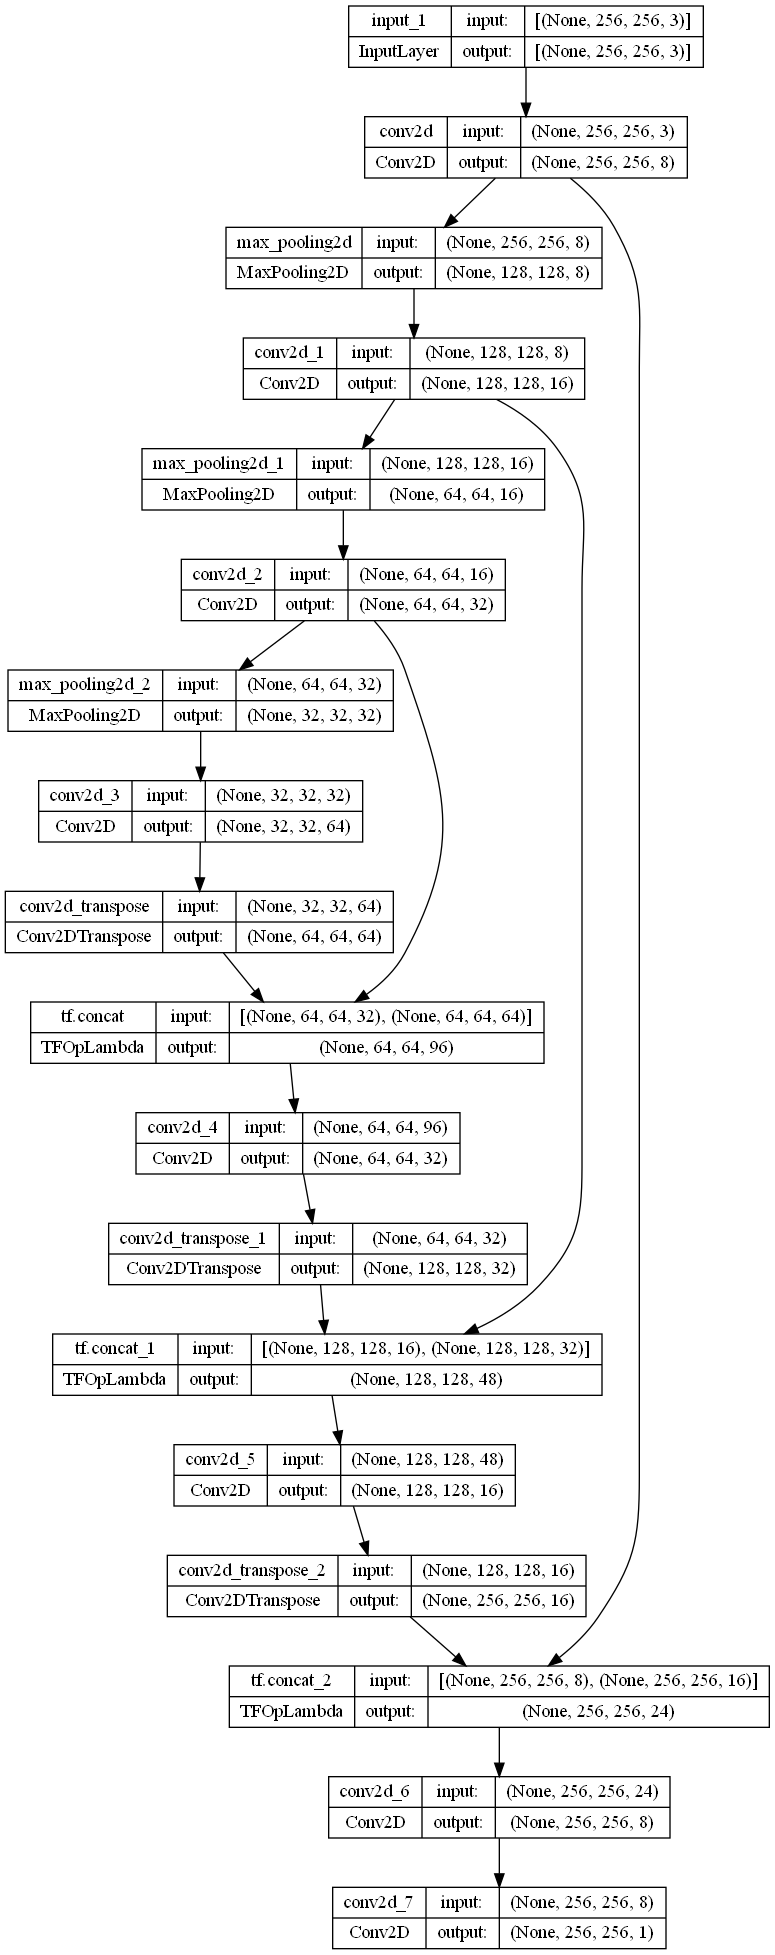

In [52]:
keras.utils.plot_model(model, "mini_unet.png", show_shapes=True) 

In [7]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [8]:
Unet_Model = model.fit(Train_Sat_Array, Train_Mask_Array,
                       epochs=50,
                       validation_data=(Val_Sat_Array, Val_Mask_Array),
                       callbacks=callbacks)

Epoch 1/50
156/156 [==============================] - 644s 4s/step - loss: 0.3435 - accuracy: 0.8876 - val_loss: 0.2163 - val_accuracy: 0.9541
Epoch 2/50
156/156 [==============================] - 611s 4s/step - loss: 0.2028 - accuracy: 0.9536 - val_loss: 0.1911 - val_accuracy: 0.9541
Epoch 3/50
156/156 [==============================] - 678s 4s/step - loss: 0.1861 - accuracy: 0.9536 - val_loss: 0.1795 - val_accuracy: 0.9541
Epoch 4/50
156/156 [==============================] - 672s 4s/step - loss: 0.1774 - accuracy: 0.9536 - val_loss: 0.1743 - val_accuracy: 0.9541
Epoch 5/50
156/156 [==============================] - 688s 4s/step - loss: 0.1715 - accuracy: 0.9536 - val_loss: 0.1676 - val_accuracy: 0.9541
Epoch 6/50
156/156 [==============================] - 791s 5s/step - loss: 0.1664 - accuracy: 0.9536 - val_loss: 0.1630 - val_accuracy: 0.9541
Epoch 7/50
156/156 [==============================] - 758s 5s/step - loss: 0.1631 - accuracy: 0.9536 - val_loss: 0.1596 - val_accuracy: 0.9541

In [9]:
# Save complete model for later use
model.save('Unet256.h5')

In [ ]:
# Load the complete model
model = load_model('Unet256.h5')

In [10]:
os.listdir(checkpoint_dir)

['checkpoint', 'modelcheck.data-00000-of-00001', 'modelcheck.index']

In [11]:
# Load the weights
weights = model.load_weights(checkpoint_path)

# Results

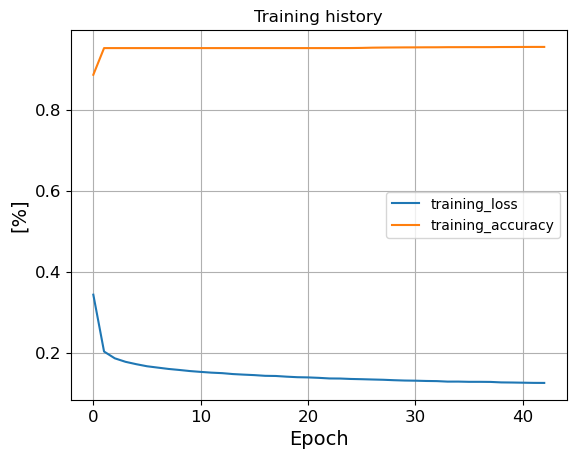

In [12]:
# Training History
plt.plot(Unet_Model.history['loss'], label = 'training_loss')
plt.plot(Unet_Model.history['accuracy'], label = 'training_accuracy')
plt.title('Training history')
plt.xlabel('Epoch')
plt.ylabel('[%]')
plt.legend()
plt.grid(True)

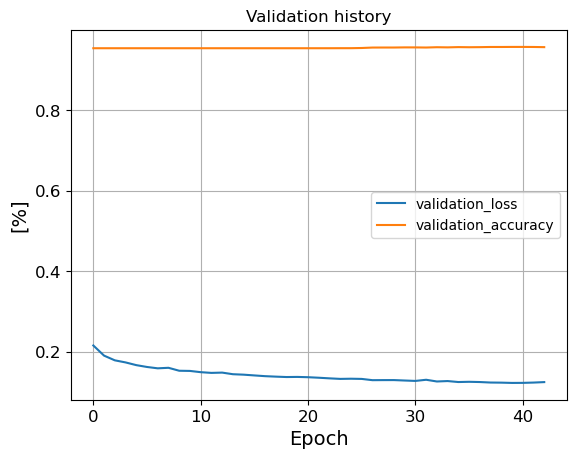

In [13]:
# Validation History
plt.plot(Unet_Model.history['val_loss'], label='validation_loss')
plt.plot(Unet_Model.history['val_accuracy'], label='validation_accuracy')
plt.title('Validation history')
plt.xlabel('Epoch')
plt.ylabel('[%]')
plt.legend()
plt.grid(True)

In [36]:
# Make predictions on the Validation set
Val_Pred = model.predict(Val_Sat_Array)

39/39 [==============================] - 29s 745ms/step


In [37]:
print(Val_Pred.shape), print(Val_Mask_Array.shape)

(1245, 256, 256, 1)
(1245, 256, 256)


(None, None)

In [38]:
print(Val_Pred[:,:,:,0].shape)

(1245, 256, 256)


In [39]:
# Flatten the predictions and labels to 1D array
Val_Pred_flat = Val_Pred[:,:,:,0].reshape(Val_Pred.shape[0], -1)
Val_Mask_flat = Val_Mask_Array.reshape(Val_Pred.shape[0], -1)
print(Val_Pred_flat.shape), print(Val_Mask_flat.shape)

(1245, 65536)
(1245, 65536)


(None, None)

In [63]:
print(np.min(Val_Pred_flat))

5.507042e-07


In [41]:
Val_Pred_flat2 = Val_Pred_flat.reshape(-1)
Val_Pred_flat2.shape

(81592320,)

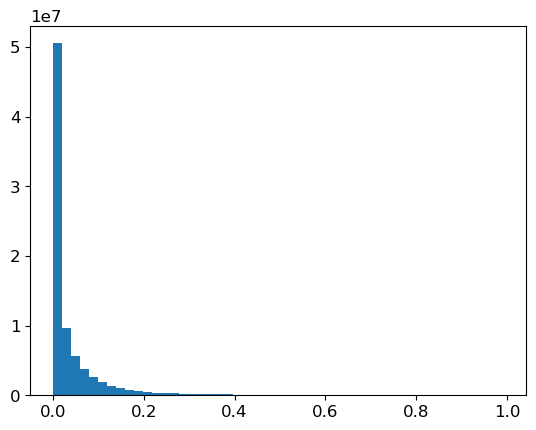

In [42]:
num_bins = 50
hist, bins = np.histogram(Val_Pred_flat2, num_bins)
plt.hist(bins[:-1], bins, weights=hist)
plt.show()

In [43]:
print(hist), print(bins)

[50527279  9725733  5681802  3810797  2634918  1861106  1347612  1004301
   764370   594204   469155   378755   309686   258604   218521   187936
   163673   144117   128905   116226   106242    97272    90849    84960
    79764    75968    72600    68001    64615    60561    56261    52146
    48374    43885    39738    35804    32097    28246    25043    21576
    18563    15581    12782    10201     8133     6269     4494     2742
     1453      400]
[5.5070421e-07 1.9853305e-02 3.9706059e-02 5.9558816e-02 7.9411566e-02
 9.9264324e-02 1.1911708e-01 1.3896984e-01 1.5882260e-01 1.7867534e-01
 1.9852810e-01 2.1838085e-01 2.3823361e-01 2.5808635e-01 2.7793911e-01
 2.9779187e-01 3.1764463e-01 3.3749738e-01 3.5735014e-01 3.7720290e-01
 3.9705566e-01 4.1690841e-01 4.3676117e-01 4.5661390e-01 4.7646666e-01
 4.9631941e-01 5.1617217e-01 5.3602493e-01 5.5587769e-01 5.7573044e-01
 5.9558320e-01 6.1543596e-01 6.3528872e-01 6.5514147e-01 6.7499423e-01
 6.9484699e-01 7.1469975e-01 7.3455250e-01 7.

(None, None)

In [64]:
# Duplicate predictions and labels, then assign binary category to each pixel relatively 
# to cutoff based on flatten pixels values (e.g. based on mean(Val_Pred_flat)). 
# cf. report for more details

cutoff_mask = 0.5
cutoff_pred =3.5*np.mean(Val_Pred_flat)

val_mask = np.zeros_like(Val_Mask_Array)
val_mask[Val_Mask_Array > cutoff_mask] = 1
val_mask[Val_Mask_Array < cutoff_mask] = 0

val_pred = np.zeros_like(Val_Pred)
val_pred[Val_Pred > cutoff_pred] = 1
val_pred[Val_Pred < cutoff_pred] = 0

val_pred_flat = val_pred[:,:,:,0].reshape(val_pred.shape[0], -1)
val_mask_flat = val_mask.reshape(val_pred.shape[0], -1)

val_pred_flat = val_pred[:,:,:,0].reshape(-1)
val_mask_flat = val_mask.reshape(-1)

print(val_mask_flat.shape), print(val_pred_flat.shape)

(81592320,)
(81592320,)


(None, None)

[Text(0.5, 1.0, 'Categorical prediction')]

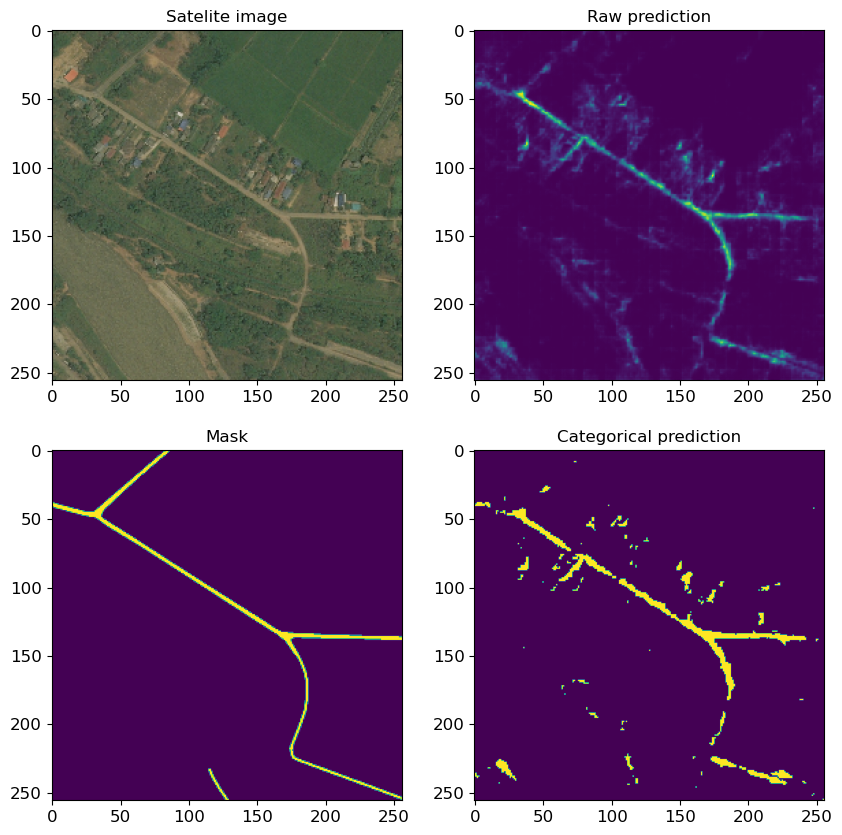

In [65]:
# plot sat image, mask image, raw prediction and threshold prediction
figure,axis = plt.subplots(2,2,figsize=(10,10))

axis[0,0].imshow(Val_Sat_Array[1,:,:])
axis[0,0].set(title='Satelite image')
axis[1,0].imshow(Val_Mask_Array[1,:,:])
axis[1,0].set(title='Mask')

axis[0,1].imshow(Val_Pred[1,:,:,:]) 
axis[0,1].set(title='Raw prediction') 
axis[1,1].imshow(val_pred[1,:,:,:]) 
axis[1,1].set(title='Categorical prediction') 

[Text(0.5, 1.0, 'Categorical prediction')]

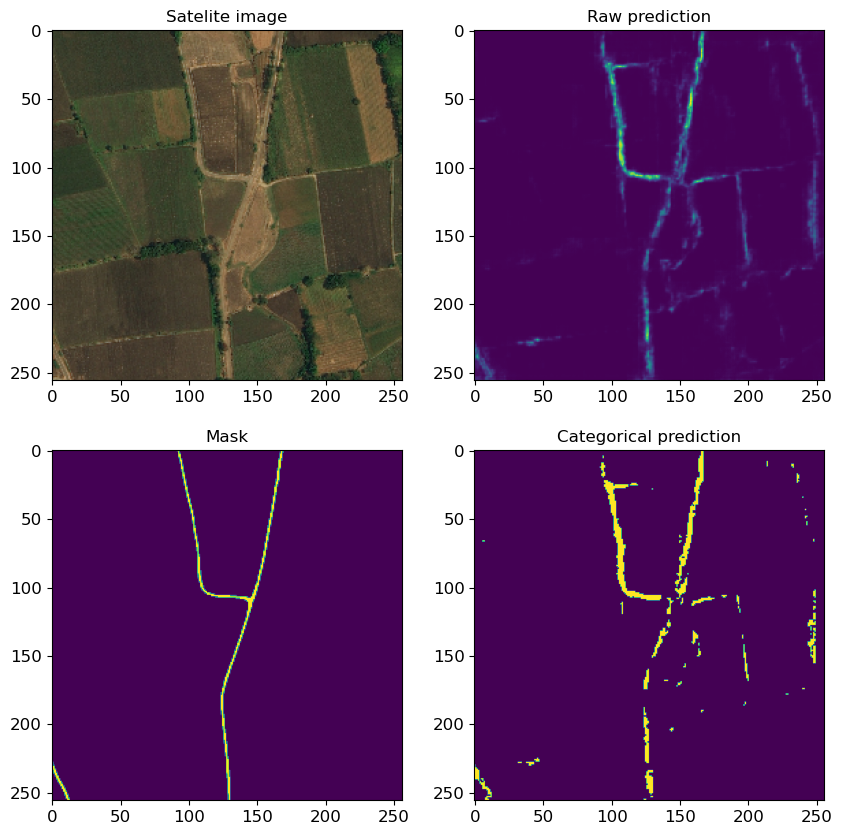

In [48]:
# plot sat image, mask image, raw prediction and threshold prediction
figure,axis = plt.subplots(2,2,figsize=(10,10))
axis[0,0].imshow(Val_Sat_Array[7,:,:])
axis[0,0].set(title='Satelite image')
axis[1,0].imshow(Val_Mask_Array[7,:,:])
axis[1,0].set(title='Mask')

axis[0,1].imshow(Val_Pred[7,:,:,:])
axis[0,1].set(title='Raw prediction')
axis[1,1].imshow(val_pred[7,:,:,:])
axis[1,1].set(title='Categorical prediction')

**Confusion Matrix**

In [49]:
# Generate a confusion matrix
cm = confusion_matrix(val_mask_flat, val_pred_flat)
print(cm.shape)

(2, 2)


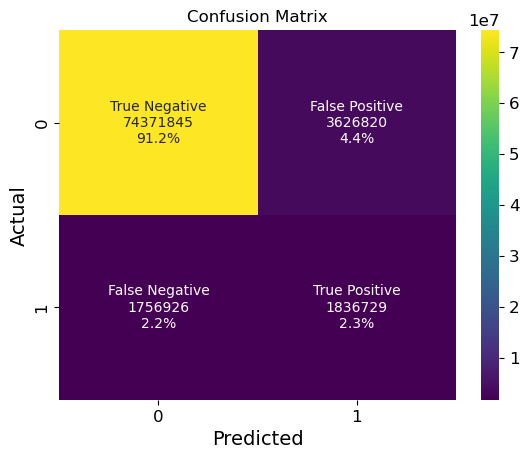

In [50]:
import seaborn as sns
# Set names to show in boxes
classes = ["True Negative","False Positive","False Negative","True Positive"]

# Set values format
values = ["{0:0.0f}".format(x) for x in cm.flatten()]

# Find percentages and set format
percentages = ["{0:.1%}".format(x) for x in cm.flatten()/np.sum(cm)]

# Combine classes, values and percentages to show 
combined = [f"{i}\n{j}\n{k}" for i, j, k in zip(classes, values, percentages)]
combined = np.asarray(combined).reshape(2,2)

b=sns.heatmap(cm, annot=combined, fmt="", cmap='viridis')
b.set(title='Confusion Matrix')
b.set(xlabel='Predicted', ylabel='Actual')
plt.show()

**F1 score**

In [51]:
# Calculate the precision, recall & F1 score
p_score = precision_score(val_mask_flat, val_pred_flat)
r_score = recall_score(val_mask_flat, val_pred_flat)
f1 = f1_score(val_mask_flat, val_pred_flat)


print("precision = ", p_score)
print("recall = ", r_score)
print("f1 score = ", f1)

precision =  0.33617873656848324
recall =  0.5111033196007964
f1 score =  0.4055841074132812


In [66]:
TN = cm[0,0]
FN = cm[1,0]
FP = cm[0,1]
TP = cm[1,1]

precision = TP/(TP+FP)
print("precision = ", precision),
recall = (TP/(TP+FN))
print("recall = ", recall),

f1_new = 2*((precision*recall)/(precision+recall))
print("f1 score = ", f1_new)

precision =  0.33617873656848324
recall =  0.5111033196007964
f1 score =  0.4055841074132812


In [14]:
# Make predictions on the Test set
Test_Pred = model.predict(Test_Sat_Array)

35/35 [==============================] - 36s 1s/step


[Text(0.5, 1.0, 'Raw prediction')]

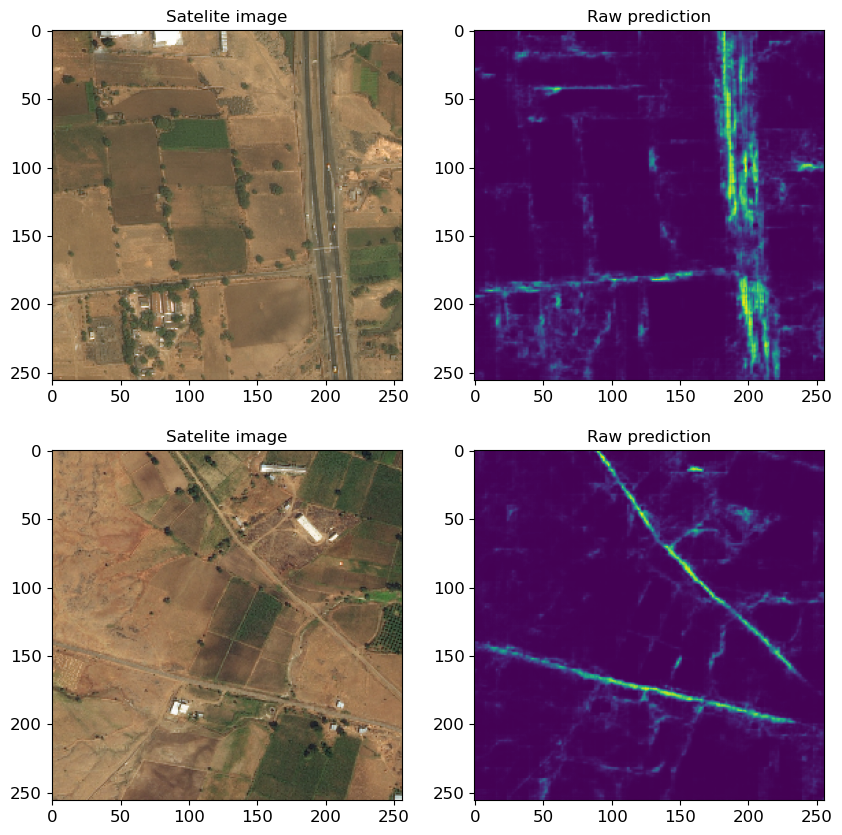

In [79]:
figure,axis = plt.subplots(2,2,figsize=(10,10))
axis[0,0].imshow(Test_Sat_Array[500,:,:])
axis[0,0].set(title='Satelite image')
axis[0,1].imshow(Test_Pred[500,:,:,:])
axis[0,1].set(title='Raw prediction')

axis[1,0].imshow(Test_Sat_Array[11,:,:])
axis[1,0].set(title='Satelite image')
axis[1,1].imshow(Test_Pred[11,:,:,:])
axis[1,1].set(title='Raw prediction')

#axis[2,0].imshow(Test_Sat_Array[100,:,:])
#axis[2,0].set(title='Satelite image')
#axis[2,1].imshow(Test_Pred[100,:,:,:])
#axis[2,1].set(title='Raw prediction')


In [18]:
Test_Pred.shape

(1101, 256, 256, 1)

In [19]:
Test_Pred_flat = Test_Pred[:,:,:,0].reshape(Test_Pred.shape[0], -1)
Test_Pred_flat2 = Test_Pred.reshape(-1)
Test_Pred_flat2.shape

(72155136,)

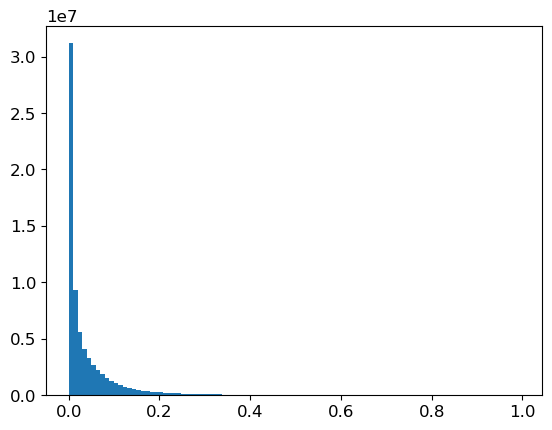

In [21]:
num_bins = 100
hist, bins = np.histogram(Test_Pred_flat2, num_bins)
plt.hist(bins[:-1], bins, weights=hist)
plt.show()

In [22]:
print(hist), print(bins)

[31177604  9300776  5614556  4114065  3258589  2669084  2212956  1842714
  1541182  1288767  1080998   914037   771703   659972   564342   486453
   420358   368134   321200   282121   248921   221320   197396   177254
   157543   143037   130272   118406   107629    99349    91377    83885
    77954    72454    67981    63102    59532    55801    52737    50231
    47450    45182    43121    41314    39701    37811    36599    34954
    34030    32934    31748    30438    29556    28745    27620    26892
    25647    24851    23846    22619    21977    20688    19879    19048
    17987    17078    16152    15427    14529    13619    12871    12144
    11076    10701     9834     9212     8447     7958     7494     6894
     6314     5739     5414     4931     4410     3940     3521     3220
     2903     2474     2136     1805     1404     1142      739      534
      349      195       84       17]
[1.9784327e-06 9.9419188e-03 1.9881859e-02 2.9821800e-02 3.9761741e-02
 4.9701679e-02 

(None, None)

In [32]:
cutoff=0.05
test_pred = np.zeros_like(Test_Pred)
test_pred[Test_Pred > cutoff] = 1
test_pred[Test_Pred < cutoff] = 0

In [24]:
test_pred.shape

(1101, 256, 256, 1)

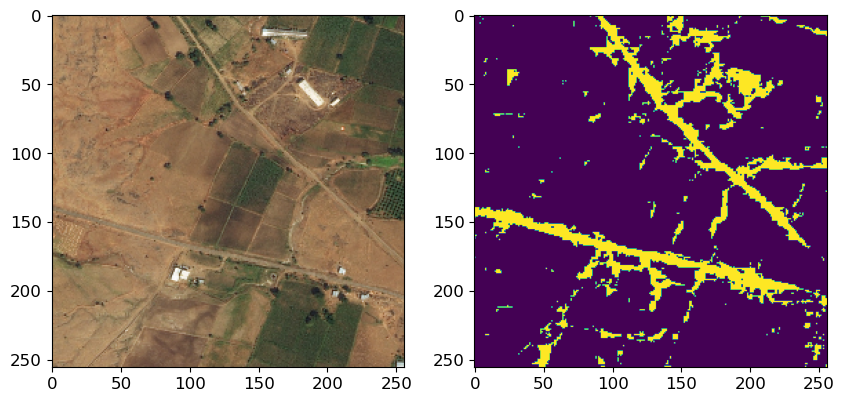

In [33]:
figure,axis = plt.subplots(1,2,figsize=(10,10))

axis[0].imshow(Test_Sat_Array[11,:,:])
axis[1].imshow(test_pred[11,:,:,:])